In [1]:
################################################################
# Scirpt_Name: FEWS_PET_Organizing.py                          #
# Purpose(s): 1. Concatenating all .bil FEWS PET datasets      #
#             2. Save as .nc format at local                   #
################################################################
# Written by Lujun Zhang @ U of Oklahoma 06/16/2020            #
# REVISION HISTORY                                             #
# 20200616 -- Initial section one completed by Lujun @ OU      #
################################################################
# Requie packages: Numpy, Pandas, necCDF4                      #
################################################################

In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
from datetime import timedelta
import sys
import os
import time
import datetime
from netCDF4 import Dataset  
from osgeo import gdal, ogr
import matplotlib.pyplot as plt
import matplotlib as mpl 
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import interp
from multiprocessing import Pool
import gdal

import warnings
warnings.filterwarnings('ignore')

In [3]:
def ReadBilFile(bil):
    import gdal
    gdal.GetDriverByName('EHdr').Register()
    img = gdal.Open(bil)
    geotransform = img.GetGeoTransform()
    band = img.GetRasterBand(1)
    data = band.ReadAsArray()

    return data, geotransform

## Test plot

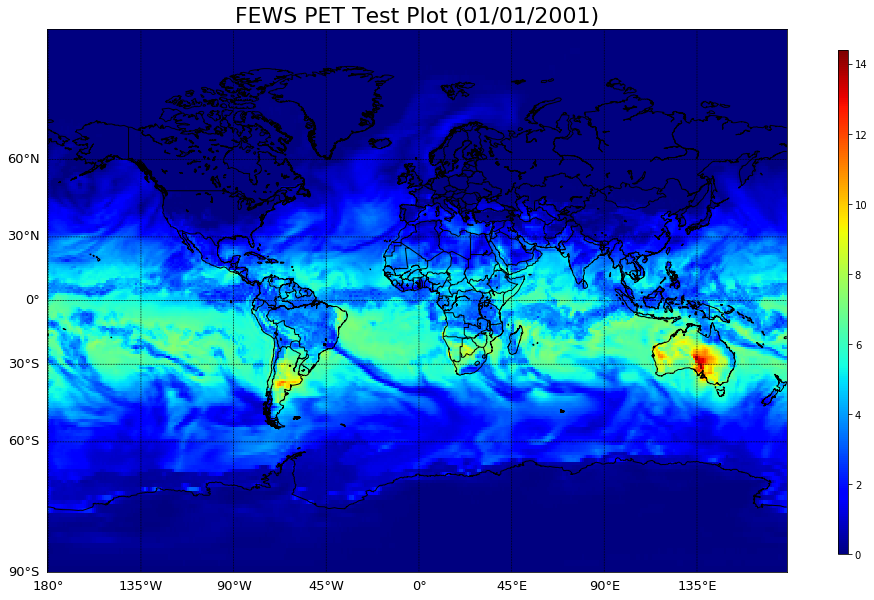

In [4]:
img = gdal.Open(r'/vsitar/F:\FEWS_PET\Raw\pet_2001\et010101.tar.gz\et010101.bil')
geotransform = img.GetGeoTransform()
originX = geotransform[0]
pixelWidth = geotransform[1]
originY = geotransform[3]
pixelHeight = geotransform[5]
band = img.GetRasterBand(1)
data = band.ReadAsArray()

Lon = sorted(np.arange(originX,originX+pixelWidth*(np.shape(data)[1]-0.001),pixelWidth)+360)
Lat = sorted(np.arange(originY+pixelHeight*(np.shape(data)[0]),originY,-pixelHeight)+0.5)

Long = Lon
Lat = Lat
# The orginal data were scaled up (multiplied by 100) to maintain a 0.01 precision
Prec = np.flip(data,axis=0)/100 

lon_min=np.min(Long); lon_max=np.max(Long)
lat_min=np.min(Lat); lat_max=np.max(Lat)

plt.figure(figsize=(14,10))
plt.title('FEWS PET Test Plot (01/01/2001)',fontsize=22)
m=Basemap(projection='mill',llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution='l')

lon,lat=np.meshgrid(Long,Lat)
lon,lat=m(lon,lat)
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)
m.drawparallels(np.arange(-90, 90,30), labels=[1,0,0,0], fontsize=13,linewidth=0.8)
m.drawmeridians(np.arange(-180, 180, 45), labels=[0,0,0,1], fontsize=13,linewidth=0.8)
cmap = plt.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Prec))
cf = plt.pcolormesh(lon,lat,Prec,cmap=cmap,norm=norm)
cax=plt.axes([0.93, 0.15, 0.01,0.7])
cbar = plt.colorbar(cf,cax=cax)

## Data organizing

In [8]:
year_range = range(2001,2020)
for i in year_range:
    # Tell if its a leap year(365 days or 366 days)
    if (i%400==0)or(i%4==0 and i%100!=0):
        j_range = 366
    else:
        j_range = 365
    # Creating dates for later str stiching
    if (i==2001):
        j_range = j_range-31 
    date = pd.date_range(start=(str(i)+'/01/01'), end=(str(i)+'/12/31'), freq="d")
    ##
    # Looping within each year "i" daily PRISM precipitation data
    print('Start orgnazing year '+str(i)+' FEWS PET data')
    for j in range(j_range):
        if(i==2001):
            k = j+31
        else:
            k = j
        date_tab = pd.to_datetime(date[k]).strftime('%Y%m%d')
        date_tab = date_tab[2:]
        bil = r'/vsitar/F:\FEWS_PET\Raw\pet_{0}\et{1}.tar.gz\et{1}.bil'.format(str(i),date_tab)
        data_tab, geotransform = ReadBilFile(bil)
        data_tab = np.flip(data_tab,axis=0)
        data_tab = np.expand_dims(data_tab,0)
        if (i==2001)&(j==0):
            # Reading & Saving GeoReference
            originX = geotransform[0]
            pixelWidth = geotransform[1]
            originY = geotransform[3]
            pixelHeight = geotransform[5]
            Lon = sorted(np.arange(originX,originX+pixelWidth*(np.shape(data_tab)[2]-0.001),pixelWidth)+360)
            Lat = sorted(np.arange(originY+pixelHeight*(np.shape(data_tab)[1]),originY,-pixelHeight)+0.5)
            ##
            # Creating "Data" to concatenate all PRISM data in one matrix
            Data = data_tab
        elif (i==2019)&(j==range(j_range)[-1]):
            Data = np.concatenate((Data,data_tab),axis=0) 
            print('Data-set shape '+str(np.shape(Data)))
            ## 
            # Save concatenated PRISM dataset at local disk
            Out_Direc = 'F:/FEWS_PET/PEWS_2001to2019_Daily_PET.nc'
            ncOutput = Dataset(Out_Direc, 'w', format='NETCDF4')
            ncOutput.createDimension('Lon', np.size(Lon))
            ncOutput.createDimension('Lat', np.size(Lat))
            ncOutput.createDimension('T', np.shape(Data)[0])
            ##
            # Add lat Variable
            var_out_Y = ncOutput.createVariable('Lat','f',("Lat"))
            ncOutput.variables['Lat'][:] = Lat[:]
            ##
            # Add lon Variable
            var_out_X = ncOutput.createVariable('Lon','f',("Lon"))
            ncOutput.variables['Lon'][:] = Lon[:]
            ##
            # Add time Variable
            var_out_S = ncOutput.createVariable('T','f',("T"))
            ncOutput.variables['T'][:] = np.arange(np.shape(Data)[0])[:]
            ##
            # Add data Variable
            var_out_data = ncOutput.createVariable('PET', 'f',("T","Lat","Lon"))
            ncOutput.variables['PET'][:,:,:] = Data[:,:,:]/100
            ##
            # attr
            ncOutput.history = "Created datatime " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + " by LujunZ at OU"
            ncOutput.source  = "netCDF4 under python 3.6.5"
            ncOutput.close()  # close the new file    
        else:
            Data = np.concatenate((Data,data_tab),axis=0)                
    print('year '+str(i)+' FEWS PET data organized!')  

Start orgnazing year 2001 FEWS PET data
year 2001 FEWS PET data organized!
Start orgnazing year 2002 FEWS PET data
year 2002 FEWS PET data organized!
Start orgnazing year 2003 FEWS PET data
year 2003 FEWS PET data organized!
Start orgnazing year 2004 FEWS PET data
year 2004 FEWS PET data organized!
Start orgnazing year 2005 FEWS PET data
year 2005 FEWS PET data organized!
Start orgnazing year 2006 FEWS PET data
year 2006 FEWS PET data organized!
Start orgnazing year 2007 FEWS PET data
year 2007 FEWS PET data organized!
Start orgnazing year 2008 FEWS PET data
year 2008 FEWS PET data organized!
Start orgnazing year 2009 FEWS PET data
year 2009 FEWS PET data organized!
Start orgnazing year 2010 FEWS PET data
year 2010 FEWS PET data organized!
Start orgnazing year 2011 FEWS PET data
year 2011 FEWS PET data organized!
Start orgnazing year 2012 FEWS PET data
year 2012 FEWS PET data organized!
Start orgnazing year 2013 FEWS PET data
year 2013 FEWS PET data organized!
Start orgnazing year 2014

## Test plot

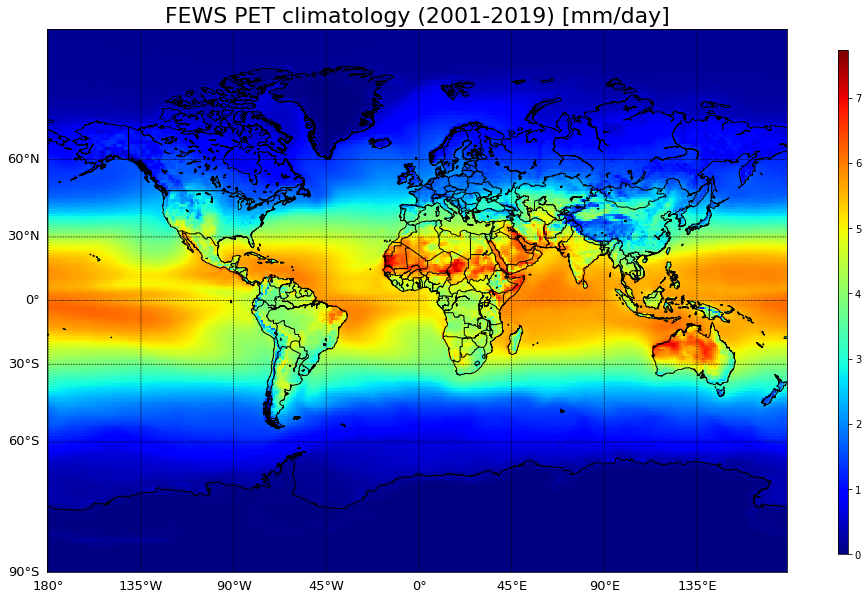

In [9]:
Data = Dataset('F:/FEWS_PET/PEWS_2001to2019_Daily_PET.nc')
Lon  = Data['Lon'][:]
Lat  = Data['Lat'][:]
Data = Data['PET'][:]

Long = Lon
Lat = Lat
# The orginal data were scaled up (multiplied by 100) to maintain a 0.01 precision
Prec = np.mean(Data,axis=0)

lon_min=np.min(Long); lon_max=np.max(Long)
lat_min=np.min(Lat); lat_max=np.max(Lat)

plt.figure(figsize=(14,10))
plt.title('FEWS PET climatology (2001-2019) [mm/day]',fontsize=22)
m=Basemap(projection='mill',llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution='l')

lon,lat=np.meshgrid(Long,Lat)
lon,lat=m(lon,lat)
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)
m.drawparallels(np.arange(-90, 90,30), labels=[1,0,0,0], fontsize=13,linewidth=0.8)
m.drawmeridians(np.arange(-180, 180, 45), labels=[0,0,0,1], fontsize=13,linewidth=0.8)
cmap = plt.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Prec))
cf = plt.pcolormesh(lon,lat,Prec,cmap=cmap,norm=norm)
cax=plt.axes([0.93, 0.15, 0.01,0.7])
cbar = plt.colorbar(cf,cax=cax)